# Classify names with character n-grams

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

## Overview of Data/Task
- Data compiled by [Sean Robertson](https://github.com/spro)
- Predict nationality from names.
- Data consist of 20074 names, 18 categories. 
- Russian names are dominant (skewing labels)
  - We downsample russian names to minimize the skew. Checkout the RNN tutorial for a different approach to handle label bias.

```
    2750 names_test.csv
   10994 names_train.csv
```

## Load names

In [11]:
!ls data/names

names_test.csv  names_train.csv


In [33]:
name_data = pd.read_csv('data/names/names_train.csv', sep='\t')
name_data = name_data.dropna()
name_data.head()

,name,label
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


## Class Breakdown

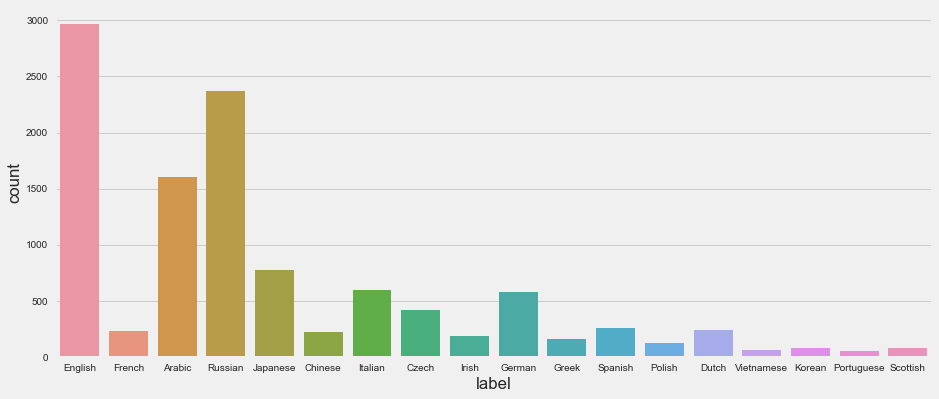

In [34]:
sns.countplot(name_data['label']);

# Feature Engineering

## 1. Lowercase

In [35]:
name_data['features'] = name_data['name'].apply(lambda x: x.lower())
name_data.head()

,name,label,features
0,Woodford,English,woodford
1,Coté,French,coté
2,Kore,English,kore
3,Koury,Arabic,koury
4,Lebzak,Russian,lebzak


## 2. Add begin and end tokens


In [36]:
def add_begin_end_tokens(name):
    # return "^{}$".format(name)
    begin_token_marker = "^"
    end_token_marker = '$'
    return "".join((begin_token_marker, name, end_token_marker))

In [37]:
name_data['features'] = name_data['features'].apply(add_begin_end_tokens)
name_data.head()

,name,label,features
0,Woodford,English,^woodford$
1,Coté,French,^coté$
2,Kore,English,^kore$
3,Koury,Arabic,^koury$
4,Lebzak,Russian,^lebzak$


## 3. Extract Character N-grams

In [38]:
def extract_n_grams(tokens, n):
    '''
    param tokens: tokenized text
    return: list of n grams
    '''
    return [tokens[i:i + n] for i in range(len(tokens) - n + 1)]

In [39]:
# use trigrams
name_data['features'] = name_data['features'].apply(lambda x: extract_n_grams(x, 3))
name_data.head()

,name,label,features
0,Woodford,English,"[^wo, woo, ood, odf, dfo, for, ord, rd$]"
1,Coté,French,"[^co, cot, oté, té$]"
2,Kore,English,"[^ko, kor, ore, re$]"
3,Koury,Arabic,"[^ko, kou, our, ury, ry$]"
4,Lebzak,Russian,"[^le, leb, ebz, bza, zak, ak$]"


## 4. Build vocabulary

In [40]:
vocabulary  = set()
for name in name_data['features'].values:
    [vocabulary.add(ngram) for ngram in name]        

In [41]:
maxlen = max(name_data['features'].apply(len))
maxlen

17

## 5. Map n-grams to indices

In [42]:
ngram_to_index = {ngram:i for i, ngram in enumerate(vocabulary)}

In [43]:
def n_grams_to_indices(n_grams):
    unknown_index = len(ngram_to_index) + 1
    return [ngram_to_index.get(ngram, unknown_index) for ngram in n_grams]  

In [44]:
n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])

[800, 4351, 5855, 3378, 5691]

## 6. Pad indices

In [107]:
def pad_indices(indices, maxlen=20):
    padded = np.zeros(maxlen, dtype=np.int64)
    for i, index in enumerate(indices):
        padded[i] = index
    return padded 

In [108]:
test_name = n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])
pad_indices(test_name, 20)

array([ 800, 4351, 5855, 3378, 5691,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

## 7. Encode class labels as numbers

In [47]:
label_to_number = {y: i for i, y in enumerate(set(name_data['label']))}
number_to_label = {i: y for i, y in enumerate(set(name_data['label']))}

In [70]:
label_to_number

18

## 8. Consolidate data preperation pipeline

In [49]:
import torch

In [52]:
def extract_name_features(name, n_grams=3):
    """
    Applies feature extraction pipeline to name
    """
    features = name.lower()
    features = add_begin_end_tokens(name)
    features = extract_n_grams(features, n_grams)
    features = n_grams_to_indices(features)
    features = pad_indices(features)
    features = torch.from_numpy(features).long()
    return features

In [ ]:
extract_name_features('Brian')

## Create PyTorch Dataset

In [97]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [112]:
class NamesDataset(Dataset):
    """Name Classification dataset"""

    def __init__(self, path):
        self.data = pd.read_csv(path, sep='\t').dropna()
        self.X = self.data['name'].apply(lambda x: extract_name_features(x, 3))
        self.y = self.data['label'].apply(lambda x: label_to_number[x])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X.iloc[index]
        y = self.y.iloc[index]
        sample = {'X': X, 'y': y}
        return sample

In [113]:
name_dataset = NamesDataset('data/names/names_train.csv')

In [111]:
type(name_dataset.X[0])

torch.LongTensor

In [114]:
dataloader = DataLoader(name_dataset, batch_size=64, shuffle=True)

## Define MLP

In [101]:
import torch.nn as nn
import torch.nn.functional as F

In [139]:
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, maxlen):
        super(MLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * maxlen, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x, apply_softmax=False):
        x = self.embeddings(x).view(-1, (embedding_dim * maxlen))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        if apply_softmax:
            x = F.softmax(x)
        return x

In [140]:
vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 100 # hidden dim.
hidden_dim = 200
output_size = len(label_to_number) # number of classes
maxlen = 20

mlp = MLP(vocab_size, embedding_dim, hidden_dim, output_size, maxlen)

## Define loss

In [141]:
criterion = nn.CrossEntropyLoss()

## Train

In [142]:
def train(model, dataloader, num_epochs):
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    loss_history = []
    for i in range(num_epochs):
        for batch in dataloader:
            model.zero_grad()
            X = Variable(batch['X'])
            y = Variable(batch['y'])
            if cuda:
                X = X.cuda()
                y = y.cuda()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        loss_history.append(loss.data[0])
        print('epoch[%d] log loss: %.4f' % (i, loss.data[0]))
    return loss_history

In [143]:
loss_history = train(mlp, dataloader, 30)

epoch[0] log loss: 1.0638
epoch[1] log loss: 1.2668
epoch[2] log loss: 0.7140
epoch[3] log loss: 0.3089
epoch[4] log loss: 0.4947
epoch[5] log loss: 0.4375
epoch[6] log loss: 0.0824
epoch[7] log loss: 0.6388
epoch[8] log loss: 0.1676
epoch[9] log loss: 0.3326
epoch[10] log loss: 0.3781
epoch[11] log loss: 0.0549
epoch[12] log loss: 0.1680
epoch[13] log loss: 0.5902
epoch[14] log loss: 0.0815
epoch[15] log loss: 0.1210
epoch[16] log loss: 0.3870
epoch[17] log loss: 0.3927
epoch[18] log loss: 0.2239
epoch[19] log loss: 0.1222
epoch[20] log loss: 0.1281
epoch[21] log loss: 0.2478
epoch[22] log loss: 0.1070
epoch[23] log loss: 0.2419
epoch[24] log loss: 0.2049
epoch[25] log loss: 0.1174
epoch[26] log loss: 0.1989
epoch[27] log loss: 0.0900
epoch[28] log loss: 0.3644
epoch[29] log loss: 0.2380


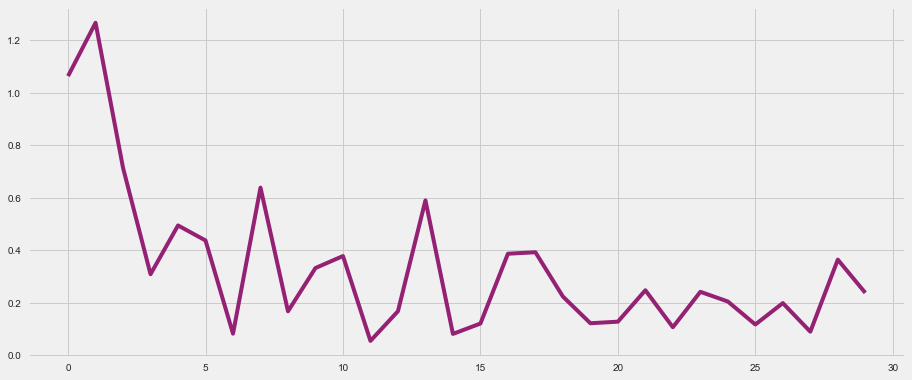

In [145]:
plt.plot(loss_history, color='#942174');

## save model

In [118]:
torch.save(mlp, 'names_mlp_model.pkl')

/Users/delip/anaconda3/envs/pinkslip/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## load model

In [119]:
mlp_from_disk = torch.load('names_mlp_model.pkl')

## Evaluate on test set

In [146]:
name_dataset_test = NamesDataset('data/names/names_test.csv')
dataloader_test = DataLoader(name_dataset_test, batch_size=4015, shuffle=False, num_workers=8)

In [147]:
def predict(model, dataloader, cuda=False):
    model.cpu()
    if cuda:
        model.cuda()
    ground_truth = []
    predictions = []
    for batch in dataloader:
        X = Variable(batch['X'])
        y = Variable(batch['y'])
        if cuda:
            X = X.cuda()
            y = y.cuda()
        outputs = model(X)
        _, y_preds = torch.max(outputs, dim=1)
        ground_truth.append(y.data.cpu().numpy())
        predictions.append(y_preds.data.cpu().squeeze().numpy())
    return np.concatenate(ground_truth), np.concatenate(predictions)

In [163]:
ground_truth, predictions = predict(mlp, dataloader_test)

In [149]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [150]:
print(accuracy_score(ground_truth, predictions)) # not relevant due to class imbalance

0.946851110302


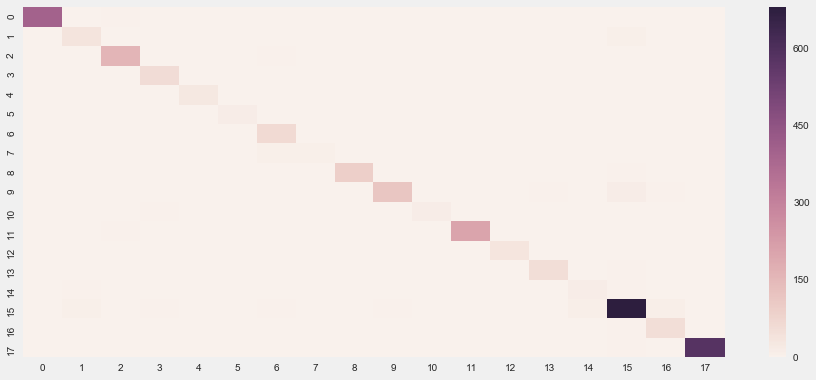

In [151]:
sns.heatmap(confusion_matrix(ground_truth, predictions));

## Exersize: run your name through the model

In [1]:
name = extract_name_features('diaz')
name = name.view(1,-1) # reshape because model expects a batch
preds = mlp(Variable(name), apply_softmax=True)
top_pred, index = torch.max(preds, dim=1)
number_to_label[index.data.tolist()[0][0]]

NameError: name 'extract_name_features' is not defined